# Meta Product2Vec


## download data

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d emmettdoolan/instacart-mba

100% 197M/198M [00:03<00:00, 53.5MB/s]
100% 198M/198M [00:03<00:00, 58.8MB/s]


In [4]:
!pip install --upgrade -q gensim 

     |████████████████████████████████| 24.1 MB 1.3 MB/s 


In [5]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from gensim.models import Word2Vec
import logging
from sklearn.decomposition import PCA
from gensim.models.callbacks import CallbackAny2Vec

In [6]:
archive = ZipFile('instacart-mba.zip')

aisles = pd.read_csv(archive.open('aisles.csv/aisles.csv'))
departments = pd.read_csv(archive.open('departments.csv/departments.csv'))
order_products_prior = pd.read_csv(archive.open('order_products__prior.csv/order_products__prior.csv'))
order_products_train = pd.read_csv(archive.open('order_products__train.csv/order_products__train.csv'))
orders = pd.read_csv(archive.open('orders.csv/orders.csv'))
products = pd.read_csv(archive.open('products.csv/products.csv'))

archive.close()

In [7]:
order_products = pd.concat([order_products_prior, order_products_train], axis=0)

In [8]:
del order_products_prior
del order_products_train

## look at data
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b


In [9]:
num_aisles = len(aisles)
num_departments = len(departments)
num_products = len(products)
num_orders = order_products['order_id'].nunique()

print(f"""There are {num_aisles} aisles 
{num_departments} departments
{num_products} products
{num_orders} orders
""")

There are 134 aisles 
21 departments
49688 products
3346083 orders



In [10]:
products_per_aisle = (pd.merge(
    products.groupby('aisle_id').size().sort_values(ascending=False).rename('num_products'), 
    aisles, 
    on='aisle_id'))

px.bar(products_per_aisle, x='aisle', y='num_products', title='Products Per Aisle')

In [11]:
products_per_department = (pd.merge(
    products.groupby('department_id').size().sort_values(ascending=False).rename('num_products'), 
    departments, 
    on='department_id'))

px.bar(products_per_department, x='department', y='num_products', title='Products Per department')

min 1
0.25 5.0
0.50 8.0
0.75 14.0
max 145



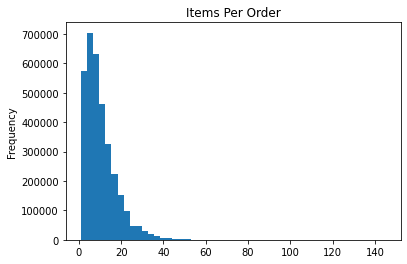

In [12]:
# order average length histogram
items_in_order = order_products.groupby('order_id').size()

# box plot is too hard to see just print
print("min", items_in_order.min())
print("0.25", items_in_order.quantile(0.25))
print("0.50", items_in_order.quantile(0.50))
print("0.75", items_in_order.quantile(0.75))
print("max", items_in_order.max())
print()

# histogram
items_in_order.plot(kind='hist', bins=50).set_title('Items Per Order');

# select few items for faster preprocessing

* the whole dataset has 33 million orders we'll take small subset of it for faster preprocessing

In [13]:
num_orders = 100000

order_ids = order_products.groupby('order_id').size().sort_values(ascending=False)[:num_orders].index
product_ids = order_products[order_products['order_id'].isin(order_ids)]['product_id'].unique()
aisles_deps = products[products['product_id'].isin(product_ids)][['aisle_id', 'department_id']]
aisle_ids = aisles_deps['aisle_id'].unique()
department_ids = aisles_deps['department_id'].unique()

print("sampled")
print("orders", len(order_ids))
print("products", len(product_ids))
print("aisles", len(aisle_ids))
print("departments", len(department_ids))


sampled
orders 100000
products 42416
aisles 134
departments 21


In [14]:
products = products[products['product_id'].isin(product_ids)]
aisles = aisles[aisles['aisle_id'].isin(aisle_ids)]
departments = departments[departments['department_id'].isin(department_ids)]
order_products = order_products[order_products['order_id'].isin(order_ids)]

## split data into windows

In [15]:
def order_to_sentence(df):
  p = 'product:' + df['product_id'].astype('str')
  a = 'aisle:' + df['aisle_id'].astype('str')
  d = 'department:' + df['department_id'].astype('str')
  df = pd.concat([p, a, d], axis=1)
  df = (
      df['product_id']
      .str.cat(df['aisle_id'], sep=' ')
      .str.cat(df['department_id'], sep=' ')
  )
  sentence = df.str.cat(sep=' ')
  return sentence

In [16]:
def test_sentence_generation():
    temp = (order_products[:5000]
            .sort_values(['order_id', 'add_to_cart_order'])
            .groupby('order_id'))

    i = 0
    for order_id, items in temp:
      items = pd.merge(items, products, on='product_id')
      print(order_to_sentence(items) + '\n')
      i += 1
      if i % 10 == 0:
        break

test_sentence_generation()

product:4210 aisle:84 department:16 product:11210 aisle:86 department:16 product:2839 aisle:96 department:20 product:19836 aisle:106 department:12 product:49505 aisle:106 department:12 product:27288 aisle:105 department:13 product:23011 aisle:43 department:3 product:37449 aisle:21 department:16 product:47144 aisle:91 department:16 product:22620 aisle:37 department:1 product:24184 aisle:83 department:4 product:18019 aisle:4 department:9 product:19539 aisle:4 department:9 product:14168 aisle:131 department:9 product:16177 aisle:105 department:13 product:21938 aisle:83 department:4 product:44455 aisle:4 department:9 product:16370 aisle:4 department:9 product:27509 aisle:129 department:1 product:42548 aisle:83 department:4 product:30958 aisle:107 department:19 product:4497 aisle:4 department:9 product:12945 aisle:9 department:9 product:39335 aisle:9 department:9 product:46167 aisle:81 department:15 product:30413 aisle:87 department:17 product:31562 aisle:83 department:4 product:38819 aisle

In [17]:
# Grab a coffee/tea. 
# Save orders into corpus file for faster processing
with open("corpus.txt", "w") as f:
  columns = ['order_id', 'product_id', 'aisle_id', 'department_id', 'add_to_cart_order']

  grouped_df = (order_products
            .sort_values(['order_id', 'add_to_cart_order'])
            .groupby('order_id'))

  batch_size = 10000
  lines = []
  i = 0

  for order_id, items in grouped_df:
      # merge item metadata
      items = pd.merge(items, products, on='product_id')

      # create sentence from order
      line = order_to_sentence(items) + '\n';
      lines.append(line)

      if (i+1) % batch_size == 0:
        f.writelines(lines)
        lines = []
        print(f"Written {i+1} orders")

      i += 1

  if len(lines) > 0:
    f.writelines(lines)

Written 10000 orders
Written 20000 orders
Written 30000 orders
Written 40000 orders
Written 50000 orders
Written 60000 orders
Written 70000 orders
Written 80000 orders
Written 90000 orders
Written 100000 orders


In [18]:
!head corpus.txt

product:8859 aisle:115 department:7 product:19731 aisle:31 department:7 product:43654 aisle:120 department:16 product:13176 aisle:24 department:4 product:4357 aisle:71 department:16 product:37664 aisle:21 department:16 product:34065 aisle:81 department:15 product:35951 aisle:91 department:16 product:43560 aisle:78 department:19 product:9896 aisle:106 department:12 product:27509 aisle:129 department:1 product:15455 aisle:19 department:13 product:27966 aisle:123 department:4 product:47601 aisle:36 department:16 product:40396 aisle:67 department:20 product:35042 aisle:59 department:15 product:40986 aisle:37 department:1 product:1939 aisle:74 department:17 product:46313 aisle:21 department:16 product:329 aisle:84 department:16 product:30776 aisle:31 department:7 product:36695 aisle:83 department:4 product:27683 aisle:59 department:15 product:15995 aisle:99 department:15 product:27344 aisle:96 department:20 product:47333 aisle:2 department:16 product:48287 aisle:34 department:1 product:4520

In [ ]:
# vocab_freq = order_products.groupby('product_id').size().to_dict()

In [ ]:
# num_sentences = order_products['order_id'].nunique()

In [ ]:
# product_id, aisle_id, department_id for each product
# num_words = len(order_products) * 3

## train word2vec on product_ids

In [19]:
WINDOW_SIZE = 21
NUM_WORKERS = 2
VECTOR_SIZE = 128

In [20]:
class EpochSaver(CallbackAny2Vec):

    '''Callback to save model after each epoch.'''
    def __init__(self, path_prefix):
        self.path_prefix = path_prefix
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch} start")
    
    def on_epoch_end(self, model):
        output_path = f"{self.path_prefix}_epoch{self.epoch}.model"
        model.save(output_path)
        self.epoch += 1

In [21]:
epochsaver = EpochSaver("meta-prod2vec")

# create skipgram word2vec model
model = Word2Vec(
        corpus_file='corpus.txt', 
        vector_size=VECTOR_SIZE,
        window=WINDOW_SIZE,
        sg=1,
        min_count=1,
        seed=42,
        workers=NUM_WORKERS,
        epochs=5,
        callbacks=[epochsaver])

Epoch 0 start
Epoch 1 start
Epoch 2 start
Epoch 3 start
Epoch 4 start


## Look at few recommendations

In [22]:
def get_product_id(product_name):
  product = products[products['product_name'] == product_name]
  if len(product) > 0:
    return product.iloc[0]['product_id']
  return None

def get_department_id(department_name):
  department = departments[departments['department'] == department_name]
  if len(department) > 0:
    return department.iloc[0]['department_id']
  return None

def get_aisle_id(aisle_name):
  aisle = aisles[aisles['aisle'] == aisle_name]
  if len(aisle) > 0:
    return aisle.iloc[0]['aisle_id']
  return None

def build_query(terms):
  query = []
  for term_type, term_name in terms:
    id = None
    if term_type == 'product':
      id = get_product_id(term_name)
    elif term_type == 'department':
      id = get_department_id(term_name)
    elif term_type == 'aisle':
      id = get_aisle_id(term_name)
    if id is not None:
      query.append(f"{term_type}:{id}")
  return query

In [23]:
build_query([
  ('product', 'Dairy Free Greek Yogurt Strawberry'),
  ('product', 'Not Exists'),
  ('aisle', 'fresh fruits'),
  ('department', 'produce'),
])

['product:41349', 'aisle:24', 'department:4']

In [44]:
def find_similar(query, topn=100):
  query = [term for term in query if model.wv.has_index_for(term)]

  if len(query) <= 0:
    return None

  similar = model.wv.most_similar(query, topn=topn)

  similar = [[
      s[0].split(":")[0], 
      s[0].split(":")[1],
      s[1]
  ] for s in similar]

  similar = pd.DataFrame(similar, columns=['type', 'id', 'score'])
  return similar  

def postprocess_similar(similar):
  if similar is None:
    return None

  similar['id'] = similar['id'].astype('int')

  similar_products = similar.query('type == "product"')[['id', 'score']]
  similar_products = pd.merge(similar_products, products, left_on='id', right_on='product_id')

  similar_aisles = similar.query('type == "aisle"')[['id', 'score']]
  similar_aisles = pd.merge(similar_aisles, aisles, left_on='id', right_on='aisle_id')

  similar_departments = similar.query('type == "department"')[['id', 'score']]
  similar_departments = pd.merge(similar_departments, departments, left_on='id', right_on='department_id')

  return {
      'products': similar_products,
      'aisles': similar_aisles,
      'departments': similar_departments,
  }

## Items similar to known item

In [45]:
# product_name = "Chocolate Sandwich Cookies"
# product_name = "Snickers Chocolate Candy"
# product_name = "Vanilla Mint Moisturizing Conditioner"
product_name = "Dairy Free Greek Yogurt Strawberry"

query = build_query([
  ('product', product_name)
])

print("Query: ", query)

similar = find_similar(query, topn=10)
similar = postprocess_similar(similar)
similar['products']

Query:  ['product:41349']


,id,score,product_id,product_name,aisle_id,department_id
0,49570,0.900868,49570,Dairy Free Greek Yogurt Blueberry,120,16
1,36835,0.871239,36835,Dairy Free Greek Yogurt Black Cherry,120,16
2,11619,0.749094,11619,Dairy Free Coconut Milk Chocolate Yogurt Alter...,120,16
3,48220,0.718750,48220,Almond Milk Peach Yogurt,120,16
4,15984,0.688995,15984,Almond Milk Blueberry Yogurt,120,16
5,22416,0.687934,22416,O'Soy Fruit on the Bottom Strawberry Organic S...,120,16
6,6123,0.687039,6123,Organic Raspberry Cultured Soy,120,16
7,31635,0.686583,31635,Vanilla Almond Milk Yogurt,120,16
8,38312,0.685548,38312,Almond Milk Strawberry Yogurt,120,16
9,19876,0.672627,19876,Organic Peach Vanilla Beverage,31,7


## Item similar to new item

In [ ]:
pd.merge(
    pd.merge(products.sample(20), aisles, on='aisle_id'),
    departments, on='department_id'
)[['product_name', 'department', 'aisle']]

In [46]:
product_name = 'Alphonso Mango' # New Item
department_name = 'produce'
aisle_name = 'fresh fruits'

query = build_query([
  ('product', product_name), 
  ('department', department_name),
  ('aisle', aisle_name),
])

print("Query ", query)

similar = find_similar(query, topn=10)
similar = postprocess_similar(similar)

Query  ['department:4', 'aisle:24']


In [47]:
similar['products']

,id,score,product_id,product_name,aisle_id,department_id
0,4920,0.775481,4920,Seedless Red Grapes,123,4
1,21137,0.773589,21137,Organic Strawberries,24,4
2,39877,0.773158,39877,Organic Granny Smith Apple,24,4
3,27104,0.769116,27104,Fresh Cauliflower,83,4
4,26209,0.759646,26209,Limes,24,4
5,39928,0.746856,39928,Organic Kiwi,24,4
6,26604,0.744848,26604,Organic Blackberries,24,4
7,39275,0.743225,39275,Organic Blueberries,123,4


In [48]:
similar['departments']

,id,score,department_id,department


In [49]:
similar['aisles']

,id,score,aisle_id,aisle
0,83,0.843076,83,fresh vegetables
1,123,0.776742,123,packaged vegetables fruits


## Items similar to last 2 items user has purchased

In [51]:
query = build_query([
  ('product', 'Chocolate Sandwich Cookies'), 
  ('product', 'Nacho Cheese White Bean Chips'),
])

print("Query ", query)

similar = find_similar(query, topn=10)
similar = postprocess_similar(similar)

Query  ['product:1', 'product:32']


In [52]:
similar['products']

,id,score,product_id,product_name,aisle_id,department_id
0,23016,0.740406,23016,Red Licorice,45,19
1,47482,0.738474,47482,Ice Cream Variety Pack,37,1
2,16550,0.719066,16550,Variety Cookies,61,19
3,27910,0.718792,27910,Chicken Burrito Bowl,13,20
4,28516,0.718451,28516,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,46,19
5,27839,0.718320,27839,49 Flavors Jelly Belly Jelly Beans,45,19
6,23423,0.715755,23423,Original Hawaiian Sweet Rolls,43,3
7,21986,0.713132,21986,Artichoke Parmesan Dip,67,20
8,16732,0.706608,16732,Peanut Milk Chocolate XXL Bag,45,19
9,21516,0.705336,21516,Gourmet Ole! Chicken Burritos,38,1


In [53]:
similar['departments']

,id,score,department_id,department


In [54]:
similar['aisles']

,id,score,aisle_id,aisle



# save to drive

In [55]:
model.save('./meta-prod2vec.model')

In [56]:
model.wv.save('meta-prod2vec.wordvectors')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [58]:
!cp ./meta-prod2vec.model /gdrive/My\ Drive/meta-prod2vec.model
!cp ./meta-prod2vec.wordvectors /gdrive/My\ Drive/meta-prod2vec.wordvectors